In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
catalogs = []

def prepare_data(df, catal_name, col_names=None):
    
    cat = catal_name
    
    if col_names is None:
        return df
    else:
        df["DM_"+cat]   = df[col_names[0]]
        df["eDM_"+cat]  = df[col_names[1]]
        df['Vcmb_'+cat] = df[col_names[2]]
        df['gSGL_'+cat] = df[col_names[3]]
        df['gSGB_'+cat] = df[col_names[4]]
       
    df["eDM_"+cat][df["DM_"+cat]==0] = np.nan
    df["DM_"+cat][df["DM_"+cat]==0] = np.nan
    df['Vcmb_'+cat][df["DM_"+cat].isna()] = np.nan
    
    columns = ["DM", "eDM", "Vcmb", "gSGL", "gSGB"]
    
    if not catal_name in catalogs:
        catalogs.append(catal_name)
    
    return df[[col+'_'+cat for col in columns]]

In [3]:
data = pd.read_csv('./CF4_SNIa.Groups.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

df = prepare_data(data, 'SNIa', ['DM', 'eDM', 'gVcmb', 'gSGL', 'gSGB'])

print(len(data))
df.head()

945


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa
PGC,,,,,
250,35.050,0.130,6894,316.3212,17.6719
282,36.040,0.110,10921,282.0792,8.9703
415,35.130,0.140,7232,320.7141,18.0434
515,34.280,0.150,4896,301.6830,13.8441
616,36.045,0.115,11210,301.3086,14.0306


In [4]:
df.loc[250]

DM_SNIa        35.0500
eDM_SNIa        0.1300
Vcmb_SNIa    6894.0000
gSGL_SNIa     316.3212
gSGB_SNIa      17.6719
Name: 250, dtype: float64

In [5]:
data = pd.read_csv('./CF4_FP_Groups_updated_2205223.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'FP', ['DM_w', 'eDM', 'gVcmb', 'gSGL', 'gSGB'])

print(len(data))

df = df.join(data, how='outer')

df.head(100)

27701


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP
PGC,,,,,,,,,,
75,NaN,NaN,NaN,NaN,NaN,36.404,0.345,11521.0,251.2392,-1.4353
115,NaN,NaN,NaN,NaN,NaN,36.270,0.590,14051.0,288.5214,11.5692
123,NaN,NaN,NaN,NaN,NaN,35.910,0.560,10964.0,278.4600,8.4002
211,NaN,NaN,NaN,NaN,NaN,36.118,0.243,10244.0,241.3354,-5.4383
250,35.05,0.13,6894.0,316.3212,17.6719,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2959,NaN,NaN,NaN,NaN,NaN,33.720,0.520,4350.0,289.5374,-0.8542
2980,NaN,NaN,NaN,NaN,NaN,32.110,0.740,1379.0,122.6505,-69.9321
3153,NaN,NaN,NaN,NaN,NaN,35.810,0.780,10985.0,268.0550,-7.3017


In [6]:
data = pd.read_csv('./CF4_TFR_Groups.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'TFR', ['DM_w', 'eDM', 'gVcmb', 'gSGL', 'gSGB'])

print(len(data))

df = df.join(data, how='outer')


df.head()

10189


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,DM_TFR,eDM_TFR,Vcmb_TFR,gSGL_TFR,gSGB_TFR
PGC,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,6179.0,286.4249,11.3510
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,11474.0,300.8070,15.3909
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,5354.0,287.6120,11.7030
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,4466.0,327.0996,19.7763
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,8404.0,321.4869,19.2652


In [7]:
data = pd.read_csv('./CF4_SBF_Groups.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'SBFm', ['DMm_w', 'eDMm', 'gVcmb', 'gSGL', 'gSGB'])
data = data.dropna()
print(len(data))

df = df.join(data, how='outer')

df.head()

177


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,DM_TFR,eDM_TFR,Vcmb_TFR,gSGL_TFR,gSGB_TFR,DM_SBFm,eDM_SBFm,Vcmb_SBFm,gSGL_SBFm,gSGB_SBFm
PGC,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,6179.0,286.4249,11.3510,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,11474.0,300.8070,15.3909,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,5354.0,287.6120,11.7030,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,4466.0,327.0996,19.7763,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,8404.0,321.4869,19.2652,NaN,NaN,NaN,NaN,NaN


In [8]:
data = pd.read_csv('./CF4_SBF_Groups.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'SBFir', ['DMir_w', 'eDMir', 'gVcmb', 'gSGL', 'gSGB'])
data = data.dropna()

print(len(data))

df = df.join(data, how='outer')

df.head()

57


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,...,DM_SBFm,eDM_SBFm,Vcmb_SBFm,gSGL_SBFm,gSGB_SBFm,DM_SBFir,eDM_SBFir,Vcmb_SBFir,gSGL_SBFir,gSGB_SBFir
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data = pd.read_csv('./CF4_SNII_Groups.csv', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'SNII', ['DM', 'eDM', 'Vcmb', 'SGL', 'SGB'])

print(len(data))

df = df.join(data, how='outer')

df.head()

94


,DM_SNIa,eDM_SNIa,Vcmb_SNIa,gSGL_SNIa,gSGB_SNIa,DM_FP,eDM_FP,Vcmb_FP,gSGL_FP,gSGB_FP,...,DM_SBFir,eDM_SBFir,Vcmb_SBFir,gSGL_SBFir,gSGB_SBFir,DM_SNII,eDM_SNII,Vcmb_SNII,gSGL_SNII,gSGB_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def merge_col(df, col='Vcmb'):
    
    columns = [x for x in df.columns.values if col in x]
    df[col] = df[columns].mean(axis=1)
    
    print(columns)
    df = df.drop(columns=columns)
    
    
    return df 


for col in ["Vcmb", "gSGL", "gSGB"]:
    df = merge_col(df, col=col)



['Vcmb_SNIa', 'Vcmb_FP', 'Vcmb_TFR', 'Vcmb_SBFm', 'Vcmb_SBFir', 'Vcmb_SNII']
['gSGL_SNIa', 'gSGL_FP', 'gSGL_TFR', 'gSGL_SBFm', 'gSGL_SBFir', 'gSGL_SNII']
['gSGB_SNIa', 'gSGB_FP', 'gSGB_TFR', 'gSGB_SBFm', 'gSGB_SBFir', 'gSGB_SNII']


In [11]:
df = df.rename(columns={'gSGL':'SGL', 'gSGB':'SGB'})


df.head()

,DM_SNIa,eDM_SNIa,DM_FP,eDM_FP,DM_TFR,eDM_TFR,DM_SBFm,eDM_SBFm,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII,Vcmb,SGL,SGB
PGC,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,34.97,0.41,NaN,NaN,NaN,NaN,NaN,NaN,6179.0,286.4249,11.3510
14,NaN,NaN,NaN,NaN,36.07,0.38,NaN,NaN,NaN,NaN,NaN,NaN,11474.0,300.8070,15.3909
16,NaN,NaN,NaN,NaN,34.63,0.45,NaN,NaN,NaN,NaN,NaN,NaN,5354.0,287.6120,11.7030
55,NaN,NaN,NaN,NaN,34.22,0.39,NaN,NaN,NaN,NaN,NaN,NaN,4466.0,327.0996,19.7763
63,NaN,NaN,NaN,NaN,35.22,0.41,NaN,NaN,NaN,NaN,NaN,NaN,8404.0,321.4869,19.2652


In [12]:
catalogs

['SNIa', 'FP', 'TFR', 'SBFm', 'SBFir', 'SNII']

In [13]:
myDict = {}

myDict["SNIa"] = 0.
myDict["FP"] = 0.127
myDict["TFR"] = 0.172
myDict["SBFm"] = 0.105
myDict["SBFir"] = 0.095
myDict["SNII"] = -0.084


for cat in catalogs:
    df['DM_'+cat] += myDict[cat]
    df['w_'+cat] = (1.-0)/df['eDM_'+cat]**2
    df['w_'+cat] = df['w_'+cat].apply(lambda x: x if x!=0 else np.nan)
    df['e_'+cat] = (1.-0)*df['eDM_'+cat]
    df['e_'+cat] = df['e_'+cat].apply(lambda x: x if x!=0 else np.nan)
    df['xw_'+cat] = (df['DM_'+cat])*df['w_'+cat]

sw = ['w_'+cat for cat in catalogs]
ee = ['e_'+cat for cat in catalogs]
sx = ['xw_'+cat for cat in catalogs]

Err2 = 1./df[sw].sum(axis=1)

df["eDM_av"] = np.sqrt(Err2)
df["DM_av"]  = df[sx].sum(axis=1)*Err2    

In [14]:
for cat in catalogs:
    edm = 'eDM_'+cat
    dm = 'DM_'+cat
    
    ## don't perform the adjsutments on the individual cataloged distances
    df['DM_'+cat] -= myDict[cat]
    
    print(dm, edm)
    
    df[edm] = df.apply(lambda x: x[edm] if x[dm]!=0 else np.nan, axis=1)
    df[dm] = df.apply(lambda x: x[dm] if x[dm]!=0 else np.nan, axis=1)

DM_SNIa eDM_SNIa
DM_FP eDM_FP
DM_TFR eDM_TFR
DM_SBFm eDM_SBFm
DM_SBFir eDM_SBFir
DM_SNII eDM_SNII


In [15]:
columns = ["DM_av", "eDM_av", "Vcmb", "SGL", "SGB"]
for cat in catalogs:
    
    columns += ['DM_'+cat]
    columns += ['eDM_'+cat]
    
df = df[columns]

df.head()

,DM_av,eDM_av,Vcmb,SGL,SGB,DM_SNIa,eDM_SNIa,DM_FP,eDM_FP,DM_TFR,eDM_TFR,DM_SBFm,eDM_SBFm,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII
PGC,,,,,,,,,,,,,,,,,
12,35.142,0.41,6179.0,286.4249,11.3510,NaN,NaN,NaN,NaN,34.97,0.41,NaN,NaN,NaN,NaN,NaN,NaN
14,36.242,0.38,11474.0,300.8070,15.3909,NaN,NaN,NaN,NaN,36.07,0.38,NaN,NaN,NaN,NaN,NaN,NaN
16,34.802,0.45,5354.0,287.6120,11.7030,NaN,NaN,NaN,NaN,34.63,0.45,NaN,NaN,NaN,NaN,NaN,NaN
55,34.392,0.39,4466.0,327.0996,19.7763,NaN,NaN,NaN,NaN,34.22,0.39,NaN,NaN,NaN,NaN,NaN,NaN
63,35.392,0.41,8404.0,321.4869,19.2652,NaN,NaN,NaN,NaN,35.22,0.41,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
cc = []
for c in df.columns[:3]:
    cc.append(c)
cc += ["RA", "DEC", "GL", "GB"]
for c in df.columns[3:]:
    cc.append(c)

cc

['DM_av',
 'eDM_av',
 'Vcmb',
 'RA',
 'DEC',
 'GL',
 'GB',
 'SGL',
 'SGB',
 'DM_SNIa',
 'eDM_SNIa',
 'DM_FP',
 'eDM_FP',
 'DM_TFR',
 'eDM_TFR',
 'DM_SBFm',
 'eDM_SBFm',
 'DM_SBFir',
 'eDM_SBFir',
 'DM_SNII',
 'eDM_SNII']

In [17]:
from kapteyn import wcs

super2celestial = wcs.Transformation("supergalactic j2000 j2000", "equatorial")
# RA, DEC = ((sgl, sgb))
super2galactic = wcs.Transformation("supergalactic j2000 j2000", "galactic")
# gl, gb = tran((sgl, sgb))

In [18]:
df["RA"] = df.apply(lambda x: super2celestial((x.SGL,x.SGB))[0], axis=1)
df["DEC"] = df.apply(lambda x: super2celestial((x.SGL,x.SGB))[1], axis=1)

df["GL"] = df.apply(lambda x: super2galactic((x.SGL,x.SGB))[0], axis=1)
df["GB"] = df.apply(lambda x: super2galactic((x.SGL,x.SGB))[1], axis=1)

df[cc].head()

,DM_av,eDM_av,Vcmb,RA,DEC,GL,GB,SGL,SGB,DM_SNIa,...,DM_FP,eDM_FP,DM_TFR,eDM_TFR,DM_SBFm,eDM_SBFm,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,35.142,0.41,6179.0,0.035972,-6.373908,90.192153,-65.929994,286.4249,11.3510,NaN,...,NaN,NaN,34.97,0.41,NaN,NaN,NaN,NaN,NaN,NaN
14,36.242,0.38,11474.0,359.980535,8.184610,101.660038,-52.546451,300.8070,15.3909,NaN,...,NaN,NaN,36.07,0.38,NaN,NaN,NaN,NaN,NaN,NaN
16,34.802,0.45,5354.0,0.047049,-5.158708,91.600561,-64.865477,287.6120,11.7030,NaN,...,NaN,NaN,34.63,0.45,NaN,NaN,NaN,NaN,NaN,NaN
55,34.392,0.39,4466.0,0.155821,33.600952,110.949487,-28.085699,327.0996,19.7763,NaN,...,NaN,NaN,34.22,0.39,NaN,NaN,NaN,NaN,NaN,NaN
63,35.392,0.41,8404.0,359.993820,28.288307,109.376188,-33.225179,321.4869,19.2652,NaN,...,NaN,NaN,35.22,0.41,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df[cc].to_csv("AllGroups_CF4_components_bar_220523.csv", sep='|')
table   = np.genfromtxt('AllGroups_CF4_components_bar_220523.csv' , delimiter='|', 
                        filling_values=-10000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["SNIa"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["PGC", "PGC1", "IDT14g", '1PGC']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int))) 
    elif key in ["Vcmb", "Vmod"]:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ["SGL", "SGB", "RA", "DEC", "GL", "GB"]:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))

## to be used on EDD
myTable.write('allcf4_group_bar_220523', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [20]:
for cols in catalogs[1:]:
    df["delta_"+cols]=df["DM_FP"]-df["DM_"+cols]
    print(cols)

# ds = df.delta.dropna()
# dss = ds[np.abs(ds.values)>0.2]

# dss

FP
TFR
SBFm
SBFir
SNII


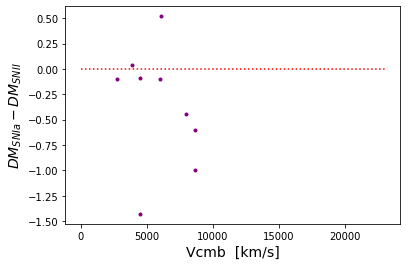

In [21]:
s = 'SNII'

plt.plot(df.Vcmb, df["delta_"+s], '.', color='purple')
plt.xlabel("Vcmb  [km/s]", fontsize=14)
plt.ylabel(r"$DM_{SNIa}-DM_{"+s+"}$", fontsize=14)

plt.plot([0,23000], [0,0], 'r:')